In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import tarfile
import math

cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('cifar-10-python.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer


def _load_label_names():
    """
    Load the label names from file
    """
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    """
    Load a batch of the dataset
    """
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)   #reshaping each image into 32*32*3
    labels = batch['labels']      #labels of each images

    return features, labels


def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    """
    Display Stats of the the dataset
    """
    batch_ids = list(range(1, 6))

    if batch_id not in batch_ids:
        print('Batch Id out of Range. Possible Batch Ids: {}'.format(batch_ids))
        return None

    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)

    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch {}:'.format(batch_id))
    print('Samples: {}'.format(len(features)))
    print('Label Counts: {}'.format(dict(zip(*np.unique(labels, return_counts=True)))))
    print('First 20 Labels: {}'.format(labels[:20]))

    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    label_names = _load_label_names()

    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    plt.axis('off')
    plt.imshow(sample_image)

def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    # TODO: Implement Function
    return x / 255 # x - np.min(x) / (np.max(x) - np.min(x))

def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    # TODO: Implement Function
    z = np.zeros((len(x), 10))
    z[list(np.indices((len(x),))) + [x]] = 1
    return z

def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    """
    Preprocess data and save it to file
    """
    features = normalize(features)
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))


def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    """
    Preprocess Training and Validation Data
    """
    n_batches = 5
    valid_features = []
    valid_labels = []
    
#preprocess nad saveing a batch of training data
    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        validation_count = int(len(features) * 0.1)

        # Prprocess and save a batch of training data
        _preprocess_and_save(
            normalize,
            one_hot_encode,
            features[:-validation_count],
            labels[:-validation_count],
            'preprocess_batch_' + str(batch_i) + '.p')

        # Use a portion of training batch for validation
        valid_features.extend(features[-validation_count:])
        valid_labels.extend(labels[-validation_count:])

# Preprocess and Save all validation data
    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(valid_features),
        np.array(valid_labels),
        'preprocess_validation.p')
    
#preprocessing test data
    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # load the test data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    # Preprocess and Save all test data
    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(test_features),
        np.array(test_labels),
        'preprocess_training.p')


def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]


def load_preprocess_training_batch(batch_id, batch_size):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))

    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(features, labels, batch_size)


def display_image_predictions(features, labels, predictions):
    n_classes = 10
    label_names = _load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axies = plt.subplots(nrows=4, ncols=2)
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

    n_predictions = 3
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions

    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        pred_names = [label_names[pred_i] for pred_i in pred_indicies]
        correct_name = label_names[label_id]

        axies[image_i][0].imshow(feature)
        axies[image_i][0].set_title(correct_name)
        axies[image_i][0].set_axis_off()

        axies[image_i][1].barh(ind + margin, pred_values[::-1], width)
        axies[image_i][1].set_yticks(ind + margin)
        axies[image_i][1].set_yticklabels(pred_names[::-1])
        axies[image_i][1].set_xticks([0, 0.5, 1.0])


Stats of batch 3:
Samples: 10000
Label Counts: {0: 994, 1: 1042, 2: 965, 3: 997, 4: 990, 5: 1029, 6: 978, 7: 1015, 8: 961, 9: 1029}
First 20 Labels: [8, 5, 0, 6, 9, 2, 8, 3, 6, 2, 7, 4, 6, 9, 0, 0, 7, 3, 7, 2]

Example of Image 5:
Image - Min Value: 9 Max Value: 255
Image - Shape: (32, 32, 3)
Label - Label Id: 2 Name: bird


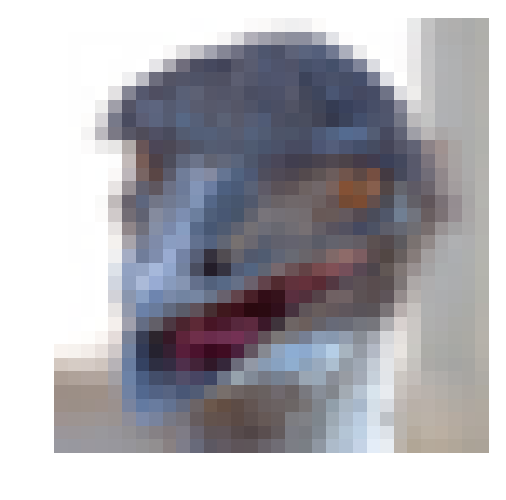

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
# Explore the dataset
batch_id = 3
sample_id = 5
display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

In [4]:
import tensorflow as tf
#import math
#from tensorflow.examples.tutorials.mnist import input_data as mnist_data
print("Tensorflow version " + tf.__version__)
tf.set_random_seed(0.0)


C:\Users\PRAKASH\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Tensorflow version 1.6.0


In [5]:
preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)
# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

In [6]:
# neural network structure for this sample:
#
# · · · · · · · · · ·      (input data, 3-deep)                    X [batch, 32, 32, 3]
# @ @ @ @ @ @ @ @ @ @   -- conv. layer +BN stride 1                W1 [6, 6, 3, 24]        B1 [24]
# ∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶                                                Y1 [batch, 28, 28, 6]
#   @ @ @ @ @ @ @ @     -- conv. layer +BN stride 2                W2 [5, 5, 24, 48]        B2 [48]
#   ∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶                                                Y2 [batch, 14, 14, 12]
#     @ @ @ @ @ @       -- conv. layer +BN stride 2                W3 [4, 4, 48, 64]       B3 [64]
#     ∶∶∶∶∶∶∶∶∶∶∶                                                 Y3 [batch, 7, 7, 24] => reshaped to YY [batch, 7*7*24]
#      \x/x\x\x/ ✞      -- fully connected layer (relu+dropout+BN) W4 [8*8*64, 200]       B4 [200]
#       · · · ·                                                    Y4 [batch, 200]
#       \x/x\x/         -- fully connected layer (softmax)          W5 [200, 10]           B5 [10]
#        · · ·                                                      Y [batch, 10]

In [7]:
# input X: 32x32x3 images, the first dimension (None) will index the images in the mini-batch
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
# correct answers will go here
Y_ = tf.placeholder(tf.float32, [None, 10])

# dropout probability
pkeep = tf.placeholder(tf.float32)
pkeep_conv = tf.placeholder(tf.float32)

In [8]:
# test flag for batch norm
tst = tf.placeholder(tf.bool)
iter = tf.placeholder(tf.int32)

def batchnorm(Ylogits, is_test, iteration, offset, convolutional=False):
    exp_moving_avg = tf.train.ExponentialMovingAverage(0.999, iteration) # adding the iteration prevents from averaging across non-existing iterations
    bnepsilon = 1e-5
    if convolutional:
        mean, variance = tf.nn.moments(Ylogits, [0, 1, 2])
    else:
        mean, variance = tf.nn.moments(Ylogits, [0])
    update_moving_averages = exp_moving_avg.apply([mean, variance])
    m = tf.cond(is_test, lambda: exp_moving_avg.average(mean), lambda: mean)
    v = tf.cond(is_test, lambda: exp_moving_avg.average(variance), lambda: variance)
    Ybn = tf.nn.batch_normalization(Ylogits, m, v, offset, None, bnepsilon)
    return Ybn, update_moving_averages

In [9]:
# three convolutional layers with their channel counts, and a
# fully connected layer (tha last layer has 10 softmax neurons)
K = 24  # first convolutional layer output depth
L = 48  # second convolutional layer output depth
M = 64  # third convolutional layer
N = 200  # fully connected layer

initializer = tf.contrib.layers.xavier_initializer_conv2d()
W1 = tf.get_variable("W1", shape=[6, 6, 3, K], initializer=initializer)    # 6x6 patch, 1 input channel, K output channels
B1 = tf.Variable(tf.constant(0.1, tf.float32, [K]))
W2 = tf.get_variable("W2", shape=[5, 5, K, L], initializer=initializer)
B2 = tf.Variable(tf.constant(0.1, tf.float32, [L]))
W3 = tf.get_variable("W3", shape=[4, 4, L, M], initializer=initializer)
B3 = tf.Variable(tf.constant(0.1, tf.float32, [M]))

W4 = tf.get_variable("W4", shape=[8*8*M, N], initializer=initializer)
B4 = tf.Variable(tf.constant(0.1, tf.float32, [N]))
W5 = tf.get_variable("W5", shape=[N, 10], initializer=initializer)
B5 = tf.Variable(tf.constant(0.1, tf.float32, [10]))

In [10]:
# batch norm scaling is not useful with relus
# batch norm offsets are used instead of biases
stride = 1
Y1l = tf.nn.conv2d(X, W1, strides=[1, stride, stride, 1], padding='SAME')
Y1bn, update_ema1 = batchnorm(Y1l, tst, iter, B1, convolutional=True)
Y1r = tf.nn.relu(Y1bn)
Y1 = tf.nn.dropout(Y1r, pkeep_conv)

stride = 2
Y2l = tf.nn.conv2d(Y1, W2, strides=[1, stride, stride, 1], padding='SAME')
Y2bn, update_ema2 = batchnorm(Y2l, tst, iter, B2, convolutional=True)
Y2r = tf.nn.relu(Y2bn)
Y2 = tf.nn.dropout(Y2r, pkeep_conv)

stride = 2
Y3l = tf.nn.conv2d(Y2, W3, strides=[1, stride, stride, 1], padding='SAME')
Y3bn, update_ema3 = batchnorm(Y3l, tst, iter, B3, convolutional=True)
Y3r = tf.nn.relu(Y3bn)
Y3 = tf.nn.dropout(Y3r, pkeep_conv)

# reshape the output from the third convolution for the fully connected layer
YY = tf.reshape(Y3, shape=[-1, 8 * 8 * M])

Y4l = tf.matmul(YY, W4)
Y4bn, update_ema4 = batchnorm(Y4l, tst, iter, B4)
Y4r = tf.nn.relu(Y4bn)
Y4 = tf.nn.dropout(Y4r, pkeep)

Ylogits = tf.matmul(Y4, W5) + B5
Y = tf.nn.softmax(Ylogits)

update_ema = tf.group(update_ema1, update_ema2, update_ema3, update_ema4)


In [11]:
# cross-entropy loss function (= -sum(Y_i * log(Yi)) ), normalised for batches of 100  images
# TensorFlow provides the softmax_cross_entropy_with_logits function to avoid numerical stability
# problems with log(0) which is NaN
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=Ylogits, labels=Y_)
cross_entropy = tf.reduce_mean(cross_entropy)*100

# accuracy of the trained model, between 0 (worst) and 1 (best)
correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [12]:
# training step
# the learning rate is: # 0.0001 + 0.03 * (1/e)^(step/1000)), i.e. exponential decay from 0.03->0.0001
lr = 0.0001 +  tf.train.exponential_decay(0.02, iter, 1600, 1/math.e)
train_step = tf.train.AdamOptimizer(lr).minimize(cross_entropy)

In [13]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [14]:
def train_neural_network(sess, train_step, pkeep, pkeep_conv, batch_X, batch_Y):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    # TODO: Implement Function
    sess.run(train_step, feed_dict={X: batch_X, Y_: batch_Y, iter: epoch, tst: False, pkeep: 1.0, pkeep_conv: 1.0})
    sess.run(update_ema, feed_dict={X: batch_X, Y_: batch_Y, iter: epoch, tst: False, pkeep: 1.0, pkeep_conv: 1.0})

In [15]:
def print_stats(sess, batch_X, batch_Y, cross_entropy, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    valid_acc = sess.run(accuracy, feed_dict={X: valid_features, Y_: valid_labels,
                                                                        iter: epoch, tst: False, pkeep: 1.0, pkeep_conv: 1.0})
    loss, l = sess.run([cross_entropy, lr], feed_dict={X: batch_X, Y_: batch_Y,
                                                                        iter: epoch, tst: False, pkeep: 1.0, pkeep_conv: 1.0})

    print('Loss: {:>10.4f} Validation Accuracy: {:.6f} with learning rate: {:.4f}'.format(loss, valid_acc, l))

In [22]:
epochs = 10
batch_size = 256

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_X, batch_Y in load_preprocess_training_batch(batch_i, batch_size):
                print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
                print_stats(sess, batch_X, batch_Y, cross_entropy, accuracy)
                train_neural_network(sess, train_step, pkeep, pkeep_conv, batch_X, batch_Y)
                print('---')



Training...
Epoch  1, CIFAR-10 Batch 1:  Loss:   281.6805 Validation Accuracy: 0.111800 with learning rate: 0.0201
---
Epoch  1, CIFAR-10 Batch 1:  Loss:   443.0370 Validation Accuracy: 0.140400 with learning rate: 0.0201
---
Epoch  1, CIFAR-10 Batch 1:  Loss:   328.5344 Validation Accuracy: 0.190000 with learning rate: 0.0201
---
Epoch  1, CIFAR-10 Batch 1:  Loss:   265.2159 Validation Accuracy: 0.224800 with learning rate: 0.0201
---
Epoch  1, CIFAR-10 Batch 1:  Loss:   239.6606 Validation Accuracy: 0.232400 with learning rate: 0.0201
---
Epoch  1, CIFAR-10 Batch 1:  Loss:   232.5047 Validation Accuracy: 0.253600 with learning rate: 0.0201
---
Epoch  1, CIFAR-10 Batch 1:  Loss:   216.5532 Validation Accuracy: 0.248200 with learning rate: 0.0201
---
Epoch  1, CIFAR-10 Batch 1:  Loss:   231.7285 Validation Accuracy: 0.245400 with learning rate: 0.0201
---
Epoch  1, CIFAR-10 Batch 1:  Loss:   220.5481 Validation Accuracy: 0.249000 with learning rate: 0.0201
---
Epoch  1, CIFAR-10 Batch 

Epoch  1, CIFAR-10 Batch 3:  Loss:   147.3211 Validation Accuracy: 0.450000 with learning rate: 0.0201
---
Epoch  1, CIFAR-10 Batch 3:  Loss:   145.4851 Validation Accuracy: 0.454800 with learning rate: 0.0201
---
Epoch  1, CIFAR-10 Batch 3:  Loss:   143.8364 Validation Accuracy: 0.461400 with learning rate: 0.0201
---
Epoch  1, CIFAR-10 Batch 3:  Loss:   149.2699 Validation Accuracy: 0.463400 with learning rate: 0.0201
---
Epoch  1, CIFAR-10 Batch 3:  Loss:   140.4493 Validation Accuracy: 0.455600 with learning rate: 0.0201
---
Epoch  1, CIFAR-10 Batch 3:  Loss:   147.7592 Validation Accuracy: 0.447600 with learning rate: 0.0201
---
Epoch  1, CIFAR-10 Batch 3:  Loss:   160.0538 Validation Accuracy: 0.457000 with learning rate: 0.0201
---
Epoch  1, CIFAR-10 Batch 3:  Loss:   145.1886 Validation Accuracy: 0.461000 with learning rate: 0.0201
---
Epoch  1, CIFAR-10 Batch 3:  Loss:   155.4020 Validation Accuracy: 0.463800 with learning rate: 0.0201
---
Epoch  1, CIFAR-10 Batch 3:  Loss:   

Epoch  1, CIFAR-10 Batch 5:  Loss:   133.3672 Validation Accuracy: 0.513400 with learning rate: 0.0201
---
Epoch  1, CIFAR-10 Batch 5:  Loss:   143.3339 Validation Accuracy: 0.512200 with learning rate: 0.0201
---
Epoch  1, CIFAR-10 Batch 5:  Loss:   130.6965 Validation Accuracy: 0.514000 with learning rate: 0.0201
---
Epoch  1, CIFAR-10 Batch 5:  Loss:   133.9870 Validation Accuracy: 0.519600 with learning rate: 0.0201
---
Epoch  1, CIFAR-10 Batch 5:  Loss:   129.2799 Validation Accuracy: 0.516000 with learning rate: 0.0201
---
Epoch  1, CIFAR-10 Batch 5:  Loss:   127.4067 Validation Accuracy: 0.514600 with learning rate: 0.0201
---
Epoch  1, CIFAR-10 Batch 5:  Loss:   142.5553 Validation Accuracy: 0.513800 with learning rate: 0.0201
---
Epoch  1, CIFAR-10 Batch 5:  Loss:   138.7489 Validation Accuracy: 0.520200 with learning rate: 0.0201
---
Epoch  1, CIFAR-10 Batch 5:  Loss:   127.6163 Validation Accuracy: 0.521600 with learning rate: 0.0201
---
Epoch  1, CIFAR-10 Batch 5:  Loss:   

Epoch  2, CIFAR-10 Batch 3:  Loss:   126.8820 Validation Accuracy: 0.543000 with learning rate: 0.0201
---
Epoch  2, CIFAR-10 Batch 3:  Loss:   130.8439 Validation Accuracy: 0.546200 with learning rate: 0.0201
---
Epoch  2, CIFAR-10 Batch 3:  Loss:   127.0452 Validation Accuracy: 0.551000 with learning rate: 0.0201
---
Epoch  2, CIFAR-10 Batch 3:  Loss:   118.6875 Validation Accuracy: 0.552400 with learning rate: 0.0201
---
Epoch  2, CIFAR-10 Batch 3:  Loss:   119.0185 Validation Accuracy: 0.550400 with learning rate: 0.0201
---
Epoch  2, CIFAR-10 Batch 3:  Loss:   126.4872 Validation Accuracy: 0.554200 with learning rate: 0.0201
---
Epoch  2, CIFAR-10 Batch 3:  Loss:   117.0565 Validation Accuracy: 0.551000 with learning rate: 0.0201
---
Epoch  2, CIFAR-10 Batch 3:  Loss:   127.8754 Validation Accuracy: 0.550600 with learning rate: 0.0201
---
Epoch  2, CIFAR-10 Batch 3:  Loss:   119.3865 Validation Accuracy: 0.560800 with learning rate: 0.0201
---
Epoch  2, CIFAR-10 Batch 3:  Loss:   

Epoch  2, CIFAR-10 Batch 5:  Loss:   120.5793 Validation Accuracy: 0.586800 with learning rate: 0.0201
---
Epoch  2, CIFAR-10 Batch 5:  Loss:   123.8876 Validation Accuracy: 0.582400 with learning rate: 0.0201
---
Epoch  2, CIFAR-10 Batch 5:  Loss:   112.2606 Validation Accuracy: 0.583400 with learning rate: 0.0201
---
Epoch  2, CIFAR-10 Batch 5:  Loss:   113.0570 Validation Accuracy: 0.584800 with learning rate: 0.0201
---
Epoch  2, CIFAR-10 Batch 5:  Loss:   127.6639 Validation Accuracy: 0.584200 with learning rate: 0.0201
---
Epoch  2, CIFAR-10 Batch 5:  Loss:   112.3824 Validation Accuracy: 0.591000 with learning rate: 0.0201
---
Epoch  2, CIFAR-10 Batch 5:  Loss:   122.2463 Validation Accuracy: 0.595200 with learning rate: 0.0201
---
Epoch  2, CIFAR-10 Batch 5:  Loss:   114.2937 Validation Accuracy: 0.585400 with learning rate: 0.0201
---
Epoch  2, CIFAR-10 Batch 5:  Loss:   117.9555 Validation Accuracy: 0.583800 with learning rate: 0.0201
---
Epoch  2, CIFAR-10 Batch 5:  Loss:   

Epoch  3, CIFAR-10 Batch 2:  Loss:   101.0324 Validation Accuracy: 0.610200 with learning rate: 0.0201
---
Epoch  3, CIFAR-10 Batch 2:  Loss:   110.4296 Validation Accuracy: 0.607800 with learning rate: 0.0201
---
Epoch  3, CIFAR-10 Batch 2:  Loss:   100.7946 Validation Accuracy: 0.607200 with learning rate: 0.0201
---
Epoch  3, CIFAR-10 Batch 2:  Loss:    97.4965 Validation Accuracy: 0.608600 with learning rate: 0.0201
---
Epoch  3, CIFAR-10 Batch 2:  Loss:   103.6422 Validation Accuracy: 0.611400 with learning rate: 0.0201
---
Epoch  3, CIFAR-10 Batch 2:  Loss:   104.2305 Validation Accuracy: 0.613600 with learning rate: 0.0201
---
Epoch  3, CIFAR-10 Batch 2:  Loss:   110.9953 Validation Accuracy: 0.614600 with learning rate: 0.0201
---
Epoch  3, CIFAR-10 Batch 2:  Loss:   102.1265 Validation Accuracy: 0.613200 with learning rate: 0.0201
---
Epoch  3, CIFAR-10 Batch 2:  Loss:    93.6453 Validation Accuracy: 0.613400 with learning rate: 0.0201
---
Epoch  3, CIFAR-10 Batch 2:  Loss:   

Epoch  3, CIFAR-10 Batch 5:  Loss:    96.6869 Validation Accuracy: 0.628000 with learning rate: 0.0201
---
Epoch  3, CIFAR-10 Batch 5:  Loss:    98.8768 Validation Accuracy: 0.628000 with learning rate: 0.0201
---
Epoch  3, CIFAR-10 Batch 5:  Loss:    82.8943 Validation Accuracy: 0.629400 with learning rate: 0.0201
---
Epoch  3, CIFAR-10 Batch 5:  Loss:   103.3190 Validation Accuracy: 0.629800 with learning rate: 0.0201
---
Epoch  3, CIFAR-10 Batch 5:  Loss:    97.9602 Validation Accuracy: 0.636000 with learning rate: 0.0201
---
Epoch  3, CIFAR-10 Batch 5:  Loss:    89.6458 Validation Accuracy: 0.640400 with learning rate: 0.0201
---
Epoch  3, CIFAR-10 Batch 5:  Loss:    95.8175 Validation Accuracy: 0.636200 with learning rate: 0.0201
---
Epoch  3, CIFAR-10 Batch 5:  Loss:    99.5394 Validation Accuracy: 0.627400 with learning rate: 0.0201
---
Epoch  3, CIFAR-10 Batch 5:  Loss:    91.9752 Validation Accuracy: 0.631600 with learning rate: 0.0201
---
Epoch  3, CIFAR-10 Batch 5:  Loss:   

Epoch  4, CIFAR-10 Batch 2:  Loss:    81.1410 Validation Accuracy: 0.650800 with learning rate: 0.0201
---
Epoch  4, CIFAR-10 Batch 2:  Loss:    85.4688 Validation Accuracy: 0.647800 with learning rate: 0.0201
---
Epoch  4, CIFAR-10 Batch 2:  Loss:   105.9656 Validation Accuracy: 0.645000 with learning rate: 0.0201
---
Epoch  4, CIFAR-10 Batch 2:  Loss:    80.4331 Validation Accuracy: 0.651600 with learning rate: 0.0201
---
Epoch  4, CIFAR-10 Batch 2:  Loss:    94.0432 Validation Accuracy: 0.660600 with learning rate: 0.0201
---
Epoch  4, CIFAR-10 Batch 2:  Loss:    86.4205 Validation Accuracy: 0.663600 with learning rate: 0.0201
---
Epoch  4, CIFAR-10 Batch 2:  Loss:    86.6415 Validation Accuracy: 0.659600 with learning rate: 0.0201
---
Epoch  4, CIFAR-10 Batch 2:  Loss:    87.2627 Validation Accuracy: 0.656600 with learning rate: 0.0201
---
Epoch  4, CIFAR-10 Batch 2:  Loss:    82.3287 Validation Accuracy: 0.650200 with learning rate: 0.0201
---
Epoch  4, CIFAR-10 Batch 2:  Loss:   

Epoch  4, CIFAR-10 Batch 4:  Loss:    75.6582 Validation Accuracy: 0.662800 with learning rate: 0.0201
---
Epoch  4, CIFAR-10 Batch 4:  Loss:    69.5394 Validation Accuracy: 0.663000 with learning rate: 0.0201
---
Epoch  4, CIFAR-10 Batch 4:  Loss:    70.4233 Validation Accuracy: 0.663000 with learning rate: 0.0201
---
Epoch  4, CIFAR-10 Batch 4:  Loss:    87.9118 Validation Accuracy: 0.665600 with learning rate: 0.0201
---
Epoch  4, CIFAR-10 Batch 4:  Loss:    80.2447 Validation Accuracy: 0.672000 with learning rate: 0.0201
---
Epoch  4, CIFAR-10 Batch 4:  Loss:    77.1312 Validation Accuracy: 0.668800 with learning rate: 0.0201
---
Epoch  4, CIFAR-10 Batch 4:  Loss:    85.7836 Validation Accuracy: 0.659000 with learning rate: 0.0201
---
Epoch  4, CIFAR-10 Batch 4:  Loss:    82.6692 Validation Accuracy: 0.658800 with learning rate: 0.0201
---
Epoch  4, CIFAR-10 Batch 4:  Loss:    77.0446 Validation Accuracy: 0.656800 with learning rate: 0.0201
---
Epoch  4, CIFAR-10 Batch 4:  Loss:   

Epoch  5, CIFAR-10 Batch 2:  Loss:    75.8418 Validation Accuracy: 0.652800 with learning rate: 0.0201
---
Epoch  5, CIFAR-10 Batch 2:  Loss:    82.7722 Validation Accuracy: 0.643800 with learning rate: 0.0201
---
Epoch  5, CIFAR-10 Batch 2:  Loss:    73.0080 Validation Accuracy: 0.639400 with learning rate: 0.0201
---
Epoch  5, CIFAR-10 Batch 2:  Loss:    83.1340 Validation Accuracy: 0.640600 with learning rate: 0.0201
---
Epoch  5, CIFAR-10 Batch 2:  Loss:    72.4205 Validation Accuracy: 0.644600 with learning rate: 0.0201
---
Epoch  5, CIFAR-10 Batch 2:  Loss:    80.8633 Validation Accuracy: 0.644600 with learning rate: 0.0201
---
Epoch  5, CIFAR-10 Batch 2:  Loss:    77.8686 Validation Accuracy: 0.649800 with learning rate: 0.0201
---
Epoch  5, CIFAR-10 Batch 2:  Loss:    75.4540 Validation Accuracy: 0.650600 with learning rate: 0.0201
---
Epoch  5, CIFAR-10 Batch 2:  Loss:    83.5395 Validation Accuracy: 0.657600 with learning rate: 0.0201
---
Epoch  5, CIFAR-10 Batch 2:  Loss:   

Epoch  5, CIFAR-10 Batch 4:  Loss:    59.0490 Validation Accuracy: 0.655600 with learning rate: 0.0201
---
Epoch  5, CIFAR-10 Batch 4:  Loss:    75.4679 Validation Accuracy: 0.654800 with learning rate: 0.0201
---
Epoch  5, CIFAR-10 Batch 4:  Loss:    66.3567 Validation Accuracy: 0.649200 with learning rate: 0.0201
---
Epoch  5, CIFAR-10 Batch 4:  Loss:    71.9033 Validation Accuracy: 0.655600 with learning rate: 0.0201
---
Epoch  5, CIFAR-10 Batch 4:  Loss:    56.4104 Validation Accuracy: 0.652400 with learning rate: 0.0201
---
Epoch  5, CIFAR-10 Batch 4:  Loss:    70.4496 Validation Accuracy: 0.653200 with learning rate: 0.0201
---
Epoch  5, CIFAR-10 Batch 4:  Loss:    68.1720 Validation Accuracy: 0.655000 with learning rate: 0.0201
---
Epoch  5, CIFAR-10 Batch 4:  Loss:    64.4411 Validation Accuracy: 0.660600 with learning rate: 0.0201
---
Epoch  5, CIFAR-10 Batch 4:  Loss:    70.1571 Validation Accuracy: 0.650800 with learning rate: 0.0201
---
Epoch  5, CIFAR-10 Batch 4:  Loss:   

Epoch  6, CIFAR-10 Batch 1:  Loss:    62.4331 Validation Accuracy: 0.655800 with learning rate: 0.0200
---
Epoch  6, CIFAR-10 Batch 1:  Loss:    63.6975 Validation Accuracy: 0.658000 with learning rate: 0.0200
---
Epoch  6, CIFAR-10 Batch 1:  Loss:    57.3057 Validation Accuracy: 0.666200 with learning rate: 0.0200
---
Epoch  6, CIFAR-10 Batch 1:  Loss:    54.9623 Validation Accuracy: 0.668400 with learning rate: 0.0200
---
Epoch  6, CIFAR-10 Batch 1:  Loss:    56.8098 Validation Accuracy: 0.665600 with learning rate: 0.0200
---
Epoch  6, CIFAR-10 Batch 1:  Loss:    57.4340 Validation Accuracy: 0.663200 with learning rate: 0.0200
---
Epoch  6, CIFAR-10 Batch 1:  Loss:    56.7903 Validation Accuracy: 0.665200 with learning rate: 0.0200
---
Epoch  6, CIFAR-10 Batch 1:  Loss:    73.2481 Validation Accuracy: 0.668800 with learning rate: 0.0200
---
Epoch  6, CIFAR-10 Batch 1:  Loss:    52.9379 Validation Accuracy: 0.671800 with learning rate: 0.0200
---
Epoch  6, CIFAR-10 Batch 1:  Loss:   

Epoch  6, CIFAR-10 Batch 4:  Loss:    47.9213 Validation Accuracy: 0.664000 with learning rate: 0.0200
---
Epoch  6, CIFAR-10 Batch 4:  Loss:    51.5434 Validation Accuracy: 0.664800 with learning rate: 0.0200
---
Epoch  6, CIFAR-10 Batch 4:  Loss:    61.8493 Validation Accuracy: 0.664000 with learning rate: 0.0200
---
Epoch  6, CIFAR-10 Batch 4:  Loss:    56.4250 Validation Accuracy: 0.660400 with learning rate: 0.0200
---
Epoch  6, CIFAR-10 Batch 4:  Loss:    54.0336 Validation Accuracy: 0.660600 with learning rate: 0.0200
---
Epoch  6, CIFAR-10 Batch 4:  Loss:    47.8533 Validation Accuracy: 0.662200 with learning rate: 0.0200
---
Epoch  6, CIFAR-10 Batch 4:  Loss:    52.3231 Validation Accuracy: 0.659600 with learning rate: 0.0200
---
Epoch  6, CIFAR-10 Batch 4:  Loss:    53.2233 Validation Accuracy: 0.667400 with learning rate: 0.0200
---
Epoch  6, CIFAR-10 Batch 4:  Loss:    62.0779 Validation Accuracy: 0.671600 with learning rate: 0.0200
---
Epoch  6, CIFAR-10 Batch 4:  Loss:   

Epoch  7, CIFAR-10 Batch 1:  Loss:    54.1871 Validation Accuracy: 0.650800 with learning rate: 0.0200
---
Epoch  7, CIFAR-10 Batch 1:  Loss:    51.7624 Validation Accuracy: 0.649200 with learning rate: 0.0200
---
Epoch  7, CIFAR-10 Batch 1:  Loss:    46.3774 Validation Accuracy: 0.649200 with learning rate: 0.0200
---
Epoch  7, CIFAR-10 Batch 1:  Loss:    55.4404 Validation Accuracy: 0.648600 with learning rate: 0.0200
---
Epoch  7, CIFAR-10 Batch 1:  Loss:    42.6234 Validation Accuracy: 0.646000 with learning rate: 0.0200
---
Epoch  7, CIFAR-10 Batch 1:  Loss:    52.6568 Validation Accuracy: 0.645400 with learning rate: 0.0200
---
Epoch  7, CIFAR-10 Batch 1:  Loss:    43.0933 Validation Accuracy: 0.643400 with learning rate: 0.0200
---
Epoch  7, CIFAR-10 Batch 1:  Loss:    51.9515 Validation Accuracy: 0.641600 with learning rate: 0.0200
---
Epoch  7, CIFAR-10 Batch 1:  Loss:    56.7048 Validation Accuracy: 0.639400 with learning rate: 0.0200
---
Epoch  7, CIFAR-10 Batch 1:  Loss:   

Epoch  7, CIFAR-10 Batch 3:  Loss:    38.0933 Validation Accuracy: 0.661200 with learning rate: 0.0200
---
Epoch  7, CIFAR-10 Batch 3:  Loss:    37.8638 Validation Accuracy: 0.659400 with learning rate: 0.0200
---
Epoch  7, CIFAR-10 Batch 3:  Loss:    45.1872 Validation Accuracy: 0.657400 with learning rate: 0.0200
---
Epoch  7, CIFAR-10 Batch 3:  Loss:    42.5306 Validation Accuracy: 0.657000 with learning rate: 0.0200
---
Epoch  7, CIFAR-10 Batch 3:  Loss:    39.3134 Validation Accuracy: 0.657600 with learning rate: 0.0200
---
Epoch  7, CIFAR-10 Batch 3:  Loss:    30.7436 Validation Accuracy: 0.657800 with learning rate: 0.0200
---
Epoch  7, CIFAR-10 Batch 3:  Loss:    33.1420 Validation Accuracy: 0.659600 with learning rate: 0.0200
---
Epoch  7, CIFAR-10 Batch 3:  Loss:    41.1945 Validation Accuracy: 0.657800 with learning rate: 0.0200
---
Epoch  7, CIFAR-10 Batch 3:  Loss:    33.2256 Validation Accuracy: 0.661200 with learning rate: 0.0200
---
Epoch  7, CIFAR-10 Batch 3:  Loss:   

Epoch  8, CIFAR-10 Batch 1:  Loss:    34.1047 Validation Accuracy: 0.648600 with learning rate: 0.0200
---
Epoch  8, CIFAR-10 Batch 1:  Loss:    33.5161 Validation Accuracy: 0.648800 with learning rate: 0.0200
---
Epoch  8, CIFAR-10 Batch 1:  Loss:    30.6301 Validation Accuracy: 0.647000 with learning rate: 0.0200
---
Epoch  8, CIFAR-10 Batch 1:  Loss:    41.2120 Validation Accuracy: 0.643400 with learning rate: 0.0200
---
Epoch  8, CIFAR-10 Batch 1:  Loss:    43.3684 Validation Accuracy: 0.649400 with learning rate: 0.0200
---
Epoch  8, CIFAR-10 Batch 1:  Loss:    38.1469 Validation Accuracy: 0.658600 with learning rate: 0.0200
---
Epoch  8, CIFAR-10 Batch 1:  Loss:    34.3178 Validation Accuracy: 0.664200 with learning rate: 0.0200
---
Epoch  8, CIFAR-10 Batch 1:  Loss:    35.5921 Validation Accuracy: 0.670600 with learning rate: 0.0200
---
Epoch  8, CIFAR-10 Batch 1:  Loss:    31.4074 Validation Accuracy: 0.670800 with learning rate: 0.0200
---
Epoch  8, CIFAR-10 Batch 1:  Loss:   

Epoch  8, CIFAR-10 Batch 3:  Loss:    24.7025 Validation Accuracy: 0.664600 with learning rate: 0.0200
---
Epoch  8, CIFAR-10 Batch 3:  Loss:    32.2501 Validation Accuracy: 0.665600 with learning rate: 0.0200
---
Epoch  8, CIFAR-10 Batch 3:  Loss:    29.7664 Validation Accuracy: 0.669800 with learning rate: 0.0200
---
Epoch  8, CIFAR-10 Batch 3:  Loss:    35.3936 Validation Accuracy: 0.669800 with learning rate: 0.0200
---
Epoch  8, CIFAR-10 Batch 3:  Loss:    28.5214 Validation Accuracy: 0.669200 with learning rate: 0.0200
---
Epoch  8, CIFAR-10 Batch 3:  Loss:    26.7932 Validation Accuracy: 0.667600 with learning rate: 0.0200
---
Epoch  8, CIFAR-10 Batch 3:  Loss:    39.0338 Validation Accuracy: 0.664200 with learning rate: 0.0200
---
Epoch  8, CIFAR-10 Batch 3:  Loss:    31.7372 Validation Accuracy: 0.665600 with learning rate: 0.0200
---
Epoch  8, CIFAR-10 Batch 3:  Loss:    32.3221 Validation Accuracy: 0.666200 with learning rate: 0.0200
---
Epoch  8, CIFAR-10 Batch 3:  Loss:   

Epoch  8, CIFAR-10 Batch 5:  Loss:    30.4527 Validation Accuracy: 0.647800 with learning rate: 0.0200
---
Epoch  8, CIFAR-10 Batch 5:  Loss:    35.9002 Validation Accuracy: 0.645200 with learning rate: 0.0200
---
Epoch  8, CIFAR-10 Batch 5:  Loss:    28.4019 Validation Accuracy: 0.648200 with learning rate: 0.0200
---
Epoch  8, CIFAR-10 Batch 5:  Loss:    27.0563 Validation Accuracy: 0.658200 with learning rate: 0.0200
---
Epoch  8, CIFAR-10 Batch 5:  Loss:    33.8463 Validation Accuracy: 0.661400 with learning rate: 0.0200
---
Epoch  8, CIFAR-10 Batch 5:  Loss:    24.5598 Validation Accuracy: 0.667600 with learning rate: 0.0200
---
Epoch  8, CIFAR-10 Batch 5:  Loss:    28.9876 Validation Accuracy: 0.672600 with learning rate: 0.0200
---
Epoch  8, CIFAR-10 Batch 5:  Loss:    27.1988 Validation Accuracy: 0.676400 with learning rate: 0.0200
---
Epoch  8, CIFAR-10 Batch 5:  Loss:    24.9068 Validation Accuracy: 0.674400 with learning rate: 0.0200
---
Epoch  8, CIFAR-10 Batch 5:  Loss:   

Epoch  9, CIFAR-10 Batch 3:  Loss:    21.2483 Validation Accuracy: 0.663600 with learning rate: 0.0200
---
Epoch  9, CIFAR-10 Batch 3:  Loss:    20.5610 Validation Accuracy: 0.664400 with learning rate: 0.0200
---
Epoch  9, CIFAR-10 Batch 3:  Loss:    21.6371 Validation Accuracy: 0.666400 with learning rate: 0.0200
---
Epoch  9, CIFAR-10 Batch 3:  Loss:    23.5637 Validation Accuracy: 0.671000 with learning rate: 0.0200
---
Epoch  9, CIFAR-10 Batch 3:  Loss:    19.1271 Validation Accuracy: 0.674200 with learning rate: 0.0200
---
Epoch  9, CIFAR-10 Batch 3:  Loss:    12.2864 Validation Accuracy: 0.678600 with learning rate: 0.0200
---
Epoch  9, CIFAR-10 Batch 3:  Loss:    15.5392 Validation Accuracy: 0.673400 with learning rate: 0.0200
---
Epoch  9, CIFAR-10 Batch 3:  Loss:    18.5377 Validation Accuracy: 0.672600 with learning rate: 0.0200
---
Epoch  9, CIFAR-10 Batch 3:  Loss:    14.7344 Validation Accuracy: 0.671200 with learning rate: 0.0200
---
Epoch  9, CIFAR-10 Batch 3:  Loss:   

Epoch  9, CIFAR-10 Batch 5:  Loss:    22.9406 Validation Accuracy: 0.665200 with learning rate: 0.0200
---
Epoch  9, CIFAR-10 Batch 5:  Loss:    17.5777 Validation Accuracy: 0.662200 with learning rate: 0.0200
---
Epoch  9, CIFAR-10 Batch 5:  Loss:    27.4739 Validation Accuracy: 0.662200 with learning rate: 0.0200
---
Epoch  9, CIFAR-10 Batch 5:  Loss:    22.3235 Validation Accuracy: 0.659400 with learning rate: 0.0200
---
Epoch  9, CIFAR-10 Batch 5:  Loss:    16.6904 Validation Accuracy: 0.656600 with learning rate: 0.0200
---
Epoch  9, CIFAR-10 Batch 5:  Loss:    17.8812 Validation Accuracy: 0.655400 with learning rate: 0.0200
---
Epoch  9, CIFAR-10 Batch 5:  Loss:    18.4824 Validation Accuracy: 0.653200 with learning rate: 0.0200
---
Epoch  9, CIFAR-10 Batch 5:  Loss:    18.6441 Validation Accuracy: 0.654000 with learning rate: 0.0200
---
Epoch  9, CIFAR-10 Batch 5:  Loss:    17.3411 Validation Accuracy: 0.654800 with learning rate: 0.0200
---
Epoch  9, CIFAR-10 Batch 5:  Loss:   

Epoch 10, CIFAR-10 Batch 2:  Loss:    17.8989 Validation Accuracy: 0.657800 with learning rate: 0.0200
---
Epoch 10, CIFAR-10 Batch 2:  Loss:    17.7350 Validation Accuracy: 0.663800 with learning rate: 0.0200
---
Epoch 10, CIFAR-10 Batch 2:  Loss:    11.2142 Validation Accuracy: 0.664000 with learning rate: 0.0200
---
Epoch 10, CIFAR-10 Batch 2:  Loss:    10.9767 Validation Accuracy: 0.662600 with learning rate: 0.0200
---
Epoch 10, CIFAR-10 Batch 2:  Loss:    14.8972 Validation Accuracy: 0.664200 with learning rate: 0.0200
---
Epoch 10, CIFAR-10 Batch 2:  Loss:    16.6015 Validation Accuracy: 0.667400 with learning rate: 0.0200
---
Epoch 10, CIFAR-10 Batch 2:  Loss:    17.1009 Validation Accuracy: 0.667600 with learning rate: 0.0200
---
Epoch 10, CIFAR-10 Batch 2:  Loss:    16.5197 Validation Accuracy: 0.671800 with learning rate: 0.0200
---
Epoch 10, CIFAR-10 Batch 2:  Loss:    17.0684 Validation Accuracy: 0.675000 with learning rate: 0.0200
---
Epoch 10, CIFAR-10 Batch 2:  Loss:   

Epoch 10, CIFAR-10 Batch 5:  Loss:    12.9722 Validation Accuracy: 0.663400 with learning rate: 0.0200
---
Epoch 10, CIFAR-10 Batch 5:  Loss:    19.6097 Validation Accuracy: 0.666400 with learning rate: 0.0200
---
Epoch 10, CIFAR-10 Batch 5:  Loss:     8.9030 Validation Accuracy: 0.668600 with learning rate: 0.0200
---
Epoch 10, CIFAR-10 Batch 5:  Loss:    13.0082 Validation Accuracy: 0.670200 with learning rate: 0.0200
---
Epoch 10, CIFAR-10 Batch 5:  Loss:    14.2671 Validation Accuracy: 0.668200 with learning rate: 0.0200
---
Epoch 10, CIFAR-10 Batch 5:  Loss:     9.7281 Validation Accuracy: 0.673200 with learning rate: 0.0200
---
Epoch 10, CIFAR-10 Batch 5:  Loss:    14.4123 Validation Accuracy: 0.672000 with learning rate: 0.0200
---
Epoch 10, CIFAR-10 Batch 5:  Loss:    20.2224 Validation Accuracy: 0.670000 with learning rate: 0.0200
---
Epoch 10, CIFAR-10 Batch 5:  Loss:    16.4607 Validation Accuracy: 0.670400 with learning rate: 0.0200
---
Epoch 10, CIFAR-10 Batch 5:  Loss:   

After 10 Epoch, we gets the validation accuracy of 67%.